##### Copyright 2020 The TensorFlow Authors.

In [4]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# MNIST classification

Based on https://www.tensorflow.org/quantum/tutorials/mnist

We build a quantum neural network (QNN) to classify a simplified version of MNIST, similar to the approach used in <a href="https://arxiv.org/pdf/1802.06002.pdf" class="external">Farhi et al</a>. The performance of the quantum neural network on this classical data problem is compared with a classical neural network.

## Setup

In [5]:
#!pip3 install -q tensorflow==2.3.1
!python3.8 -m pip install -q tensorflow==2.4.1
!python3.8 -m pip install tensorboard_plugin_profile==2.3.0
%load_ext tensorboard

Install TensorFlow Quantum:

In [6]:
#!pip3 install -q tensorflow-quantum
!python3.8 -m pip install tfq-nightly

  Using cached grpcio-1.30.0-cp38-cp38-macosx_10_9_x86_64.whl (2.8 MB)
  Attempting uninstall: grpcio
    Found existing installation: grpcio 1.32.0
    Uninstalling grpcio-1.32.0:
      Successfully uninstalled grpcio-1.32.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.4.1 requires grpcio~=1.32.0, but you have grpcio 1.30.0 which is incompatible.


Now import TensorFlow and the module dependencies:

In [1]:
import tensorflow as tf
import tensorflow_quantum as tfq

import cirq
import sympy
import numpy as np
import seaborn as sns
import collections
import datetime
# visualization tools
%matplotlib inline
import matplotlib.pyplot as plt
from cirq.contrib.svg import SVGCircuit

# set the random seed
tf.random.set_seed(137)
np.random.seed(137)

## 1. Load the data

In this tutorial you will build a binary classifier to distinguish between the digits 3 and 6, following <a href="https://arxiv.org/pdf/1802.06002.pdf" class="external">Farhi et al.</a> This section covers the data handling that:

- Loads the raw data from Keras.
- Filters the dataset to only 3s and 6s.
- Downscales the images so they fit can fit in a quantum computer.
- Removes any contradictory examples.
- Converts the binary images to Cirq circuits.
- Converts the Cirq circuits to TensorFlow Quantum circuits. 

### 1.1 Load the raw data

Load the MNIST dataset distributed with Keras. 

In [63]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Rescale the images from [0,255] to the [0.0,1.0] range.
x_train, x_test = x_train[..., np.newaxis]/255.0, x_test[..., np.newaxis]/255.0

print("Number of original training examples:", len(x_train))
print("Number of original test examples:", len(x_test))

Number of original training examples: 60000
Number of original test examples: 10000


Filter the dataset to keep just the 3s and 6s,  remove the other classes. At the same time convert the label, `y`, to boolean: `True` for `3` and `False` for 6. 

In [64]:
def filter_36(x, y):
    keep = (y == 3) | (y == 6)
    x, y = x[keep], y[keep]
    y = y == 3
    return x,y

In [65]:
x_train, y_train = filter_36(x_train, y_train)
x_test, y_test = filter_36(x_test, y_test)

print("Number of filtered training examples:", len(x_train))
print("Number of filtered test examples:", len(x_test))

Number of filtered training examples: 12049
Number of filtered test examples: 1968


Show the first example:

True


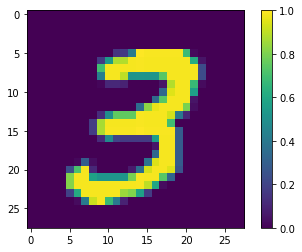

In [66]:
print(y_train[0])

plt.imshow(x_train[0, :, :, 0])
plt.colorbar()

### 1.2 Downscale the images

An image size of 28x28 is much too large for current quantum computers. Resize the image down to 4x4:

In [67]:
x_train_small = tf.image.resize(x_train, (4,4)).numpy()
x_test_small = tf.image.resize(x_test, (4,4)).numpy()

Again, display the first training example—after resize: 

True


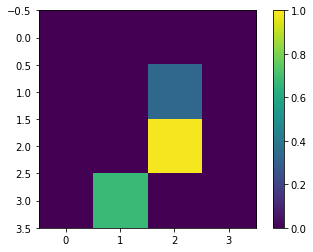

In [68]:
print(y_train[0])

plt.imshow(x_train_small[0,:,:,0], vmin=0, vmax=1)
plt.colorbar()

### 1.3 Remove contradictory examples

From section *3.3 Learning to Distinguish Digits* of <a href="https://arxiv.org/pdf/1802.06002.pdf" class="external">Farhi et al.</a>, filter the dataset to remove images that are labeled as belonging to both classes.

This is not a standard machine-learning procedure, but is included in the interest of following the paper.

In [69]:
def remove_contradicting(xs, ys):
    mapping = collections.defaultdict(set)
    orig_x = {}
    # Determine the set of labels for each unique image:
    for x,y in zip(xs,ys):
       orig_x[tuple(x.flatten())] = x
       mapping[tuple(x.flatten())].add(y)
    
    new_x = []
    new_y = []
    for flatten_x in mapping:
      x = orig_x[flatten_x]
      labels = mapping[flatten_x]
      if len(labels) == 1:
          new_x.append(x)
          new_y.append(next(iter(labels)))
      else:
          # Throw out images that match more than one label.
          pass
    
    num_uniq_3 = sum(1 for value in mapping.values() if len(value) == 1 and True in value)
    num_uniq_6 = sum(1 for value in mapping.values() if len(value) == 1 and False in value)
    num_uniq_both = sum(1 for value in mapping.values() if len(value) == 2)

    print("Number of unique images:", len(mapping.values()))
    print("Number of unique 3s: ", num_uniq_3)
    print("Number of unique 6s: ", num_uniq_6)
    print("Number of unique contradicting labels (both 3 and 6): ", num_uniq_both)
    print()
    print("Initial number of images: ", len(xs))
    print("Remaining non-contradicting unique images: ", len(new_x))
    
    return np.array(new_x), np.array(new_y)

The resulting counts do not closely match the reported values, but the exact procedure is not specified.

It is also worth noting here that applying filtering contradictory examples at this point does not totally prevent the model from receiving contradictory training examples: the next step binarizes the data which will cause more collisions. 

In [70]:
x_train_nocon, y_train_nocon = remove_contradicting(x_train_small, y_train)

Number of unique images: 10387
Number of unique 3s:  4912
Number of unique 6s:  5426
Number of unique contradicting labels (both 3 and 6):  49

Initial number of images:  12049
Remaining non-contradicting unique images:  10338


In [71]:
THRESHOLD = 0.5

x_train_bin = np.array(x_train_nocon > THRESHOLD, dtype=np.float32)
x_test_bin = np.array(x_test_small > THRESHOLD, dtype=np.float32)

In [72]:
# Duplicate some entries to illustrate the effects of dropout! Run this cell only if testing dropout
NUM_DUPLICATE = 200

for i in range(NUM_DUPLICATE):
    x_train_nocon = np.insert(x_train_nocon, 0, x_train_bin[0], axis=0)
    y_train_nocon = np.insert(y_train_nocon, 0, y_train_nocon[0], axis=0)
print(x_train_nocon.shape)
print(y_train_nocon.shape)

(10538, 4, 4, 1)
(10538,)


### 1.4 Encode the data as quantum circuits

To process images using a quantum computer, <a href="https://arxiv.org/pdf/1802.06002.pdf" class="external">Farhi et al.</a> proposed representing each pixel with a qubit, with the state depending on the value of the pixel. The first step is to convert to a binary encoding.

If you were to remove contradictory images at this point you would be left with only 193, likely not enough for effective training.

In [23]:
_ = remove_contradicting(x_train_bin, y_train_nocon)

Number of unique images: 193
Number of unique 3s:  32
Number of unique 6s:  37
Number of unique contradicting labels (both 3 and 6):  124

Initial number of images:  10338
Remaining non-contradicting unique images:  69


The qubits at pixel indices with values that exceed a threshold, are rotated through an $X$ gate.

In [73]:
def convert_to_circuit(image):
    """Encode truncated classical image into quantum datapoint."""
    values = np.ndarray.flatten(image)
    qubits = cirq.GridQubit.rect(4, 4)
    circuit = cirq.Circuit()
    for i, value in enumerate(values):
        if value:
            circuit.append(cirq.X(qubits[i]))
    return circuit


x_train_circ = [convert_to_circuit(x) for x in x_train_bin]
x_test_circ = [convert_to_circuit(x) for x in x_test_bin]

Here is the circuit created for the first example (circuit diagrams do not show qubits with zero gates):

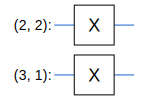

In [74]:
SVGCircuit(x_train_circ[0])

Compare this circuit to the indices where the image value exceeds the threshold:

In [75]:
bin_img = x_train_bin[0,:,:,0]
indices = np.array(np.where(bin_img)).T
indices

array([[2, 2],
       [3, 1]])

Convert these `Cirq` circuits to tensors for `tfq`:

In [76]:
x_train_tfcirc = tfq.convert_to_tensor(x_train_circ)
x_test_tfcirc = tfq.convert_to_tensor(x_test_circ)

## 2. Quantum neural network

There is little guidance for a quantum circuit structure that classifies images. Since the classification is based on the expectation of the readout qubit, <a href="https://arxiv.org/pdf/1802.06002.pdf" class="external">Farhi et al.</a> propose using two qubit gates, with the readout qubit always acted upon. This is similar in some ways to running small a <a href="https://arxiv.org/abs/1511.06464" class="external">Unitary RNN</a> across the pixels.

Helper functions for Tensorboard.


- The integer values of samples, so that you can create histograms of the distribution.
- The linear XEB fidelity estimate of a set of samples, to give some indication of how "truly quantum random" the samples are.


In [28]:
@tf.function
def bits_to_ints(bits):
    """Convert tensor of bitstrings to tensor of ints."""
    sigs = tf.constant([1 << i for i in range(N_QUBITS)], dtype=tf.int32)
    rounded_bits = tf.clip_by_value(tf.math.round(
        tf.cast(bits, dtype=tf.dtypes.float32)), clip_value_min=0, clip_value_max=1)
    return tf.einsum('jk,k->j', tf.cast(rounded_bits, dtype=tf.dtypes.int32), sigs)

@tf.function
def xeb_fid(bits):
    """Compute linear XEB fidelity of bitstrings."""
    final_probs = tf.squeeze(
        tf.abs(tfq.layers.State()(REFERENCE_CIRCUIT).to_tensor()) ** 2)
    nums = bits_to_ints(bits)
    return (2 ** N_QUBITS) * tf.reduce_mean(tf.gather(final_probs, nums)) - 1.0


### 2.1 Build the model circuit

This following example shows this layered approach. Each layer uses *n* instances of the same gate, with each of the data qubits acting on the readout qubit.

Start with a simple class that will add a layer of these gates to a circuit:

In [12]:
print(tfq.util.get_supported_gates().keys())
print(tfq.util.get_supported_channels().keys())

class CircuitLayerBuilder():
    def __init__(self, circuit, data_qubits, readout, blocks,repeat_dropout=0, overlap_dropout=False):
        
        self.data_qubits = data_qubits
        self.readout = readout
        self.curr_layer_id = 0
        self.circuit = circuit
        # for schuld impelmentation
        self.blocks  = blocks
        
        # dropout
        self.dropped_out_qubit_ids = []
        self.dropout_blacklist = []
        
        self.overlap_dropout = overlap_dropout
        
        if repeat_dropout < 1:
            repeat_dropout = 1
        if overlap_dropout:
            for _ in range(repeat_dropout - 1):
                # We will be dequeing from this on each rebuild;
                # so, each qubit will be in the list for repeat_dropout rebuilds.
                self.dropped_out_qubit_ids.append(len(self.data_qubits))
            self.delay_next_dropout = 1
        else:
            # if not overlapping, delay for as long as we're repeating
            self.delay_next_dropout = repeat_dropout
            
        self.delay_next_dropout_i = 0 # try to dropout immediately
        
        # maps str(symbol) to (is_dropped_out, weight)
        self.symbol_map = {}
        
        self.drop_out_applied = False
        
    def rebuild(self, circuit, data_qubits, readout, computed_weights, preserve_dropout=False):
        # prev_weights is the result of get_weights from the prior epoch.
        
        self.data_qubits = data_qubits
        self.readout = readout
        self.curr_layer_id = 0
        self.circuit = circuit
        
        if preserve_dropout:
            if self.overlap_dropout and len(self.dropped_out_qubit_ids) > 0 and self.drop_out_applied:
                # Dropping first element. This is either padding, or an actual id that we want to stop dropping out from here on.
                dropped_id = self.dropped_out_qubit_ids.pop(0)
                self.dropout_blacklist.append(dropped_id)
        else:
            self.dropout_blacklist = []
            self.dropped_out_qubit_ids = []
        
        if self.delay_next_dropout_i > 0:
            self.delay_next_dropout_i -= 1
        
        if self.delay_next_dropout_i == 0 and not self.overlap_dropout:
            # Dropout finished for this qubit!
            assert len(self.dropped_out_qubit_ids) <= 1
            if len(self.dropped_out_qubit_ids) == 1:
                self.dropout_blacklist.append(self.dropped_out_qubit_ids[0])
            self.dropped_out_qubit_ids = []
        
        self.drop_out_applied = False
        
        print('self.dropped_out_qubit_ids = ')
        print(self.dropped_out_qubit_ids)
        
        j = 0
        
        #print('Rebuilding; prev self.symbol_map:')
        #print(self.symbol_map)
        
        for k in sorted(self.symbol_map.keys()):
            prev_is_dropped_out, _ = self.symbol_map[k]
            if not prev_is_dropped_out:
                # Re-use the prev weight. This isn't directly used as TFQ inputs, but we later use it to generate
                # sane inputs for set_weights().
                # Also, is-dropped-out is True by default to handle the case when a rebuilt circuit might not add a layer for some reason
                self.symbol_map[k] = (True, computed_weights[j])

                # prev_weights is a list that only has entries for non-dropped-out elems
                j += 1
                
        #print('Rebuilding done; updated self.symbol_map:')
        #print(self.symbol_map)
    
    def add_layer(self, gate, blocks=None,apply_dropout=False):
        # at most one dropped qubit added per layer
        if apply_dropout and self.curr_layer_id > 0 and self.delay_next_dropout_i == 0:
            while True:
                rand_id = np.random.randint(0, len(self.data_qubits) * 2 + 1)
                if rand_id >= len(self.data_qubits):
                    rand_id = len(self.data_qubits)
                # Kinda hacky, blacklist qubits that we dropped out already
                if rand_id not in self.dropout_blacklist or rand_id == len(self.data_qubits):
                    break
            print('self.dropout_blacklist =')
            print(self.dropout_blacklist)
            #print(rand_id)
            if rand_id not in self.dropped_out_qubit_ids and rand_id != len(self.data_qubits):
                self.dropped_out_qubit_ids.append(rand_id)
            if rand_id != len(self.data_qubits):
                self.delay_next_dropout_i = self.delay_next_dropout # reset delay if we're actually going to drop out!

        for block in self.blocks:
            # first apply the initial single qubit gates
            for i in range(len(self.data_qubits)):
                qubit = self.data_qubits[i]
                symbol = sympy.Symbol('sym_l' + str(self.curr_layer_id) + '_q' + str(i))
                #self.symbol_map[str(symbol)] = (False, weight)
                self.circuit.append(gate(qubit)**symbol)

            # according to the block num create the control gates

            # add control gate version of the unitary gate if available (ie cz, cnot).
            if gate == cirq.XX:
                cgate = cirq.CNOT
            elif gate == cirq.ZZ:
                cgate = cirq.CZ
            else:
                cgate = cirq.CNOT
            target = None
            control = None
            for i in range(len(self.data_qubits)):
                if control is None:
                    control_idx = i
                    control = self.data_qubits[i]
                # determine control
                target_idx = (control_idx+len(self.data_qubits)-block)%len(self.data_qubits)
                target = self.data_qubits[target_idx]
                # add gate
                symbol = sympy.Symbol('sym_l' + str(self.curr_layer_id) + '_q' + str(i)+ 'block'+str(block))
                #self.symbol_map[str(symbol)] = (False, weight)
                self.circuit.append(cgate(control,target)**symbol)
                control = target
                control_idx = target_idx
        self.curr_layer_id += 1
    
    def get_builder_weights(self):
        # returns symbol names in sorted order, which should match the order used for PQC (kinda hacky and can potentially break later)
        # used as the next input for set_weights()
        #
        # Order of calls:
        # tf.fit();
        # builder.rebuild(tf.get_weights());
        # add_layer()...;
        # tf.set_weights(builder.get_builder_weights());
        # tf.fit()
        weights_list = []
        
        for k in sorted(self.symbol_map.keys()):
            curr_is_dropout, curr_weight = self.symbol_map[k]
            if not curr_is_dropout:
                weights_list.append(curr_weight)
        
        return weights_list

dict_keys([cirq.X, cirq.XX, cirq.Y, cirq.YY, cirq.Z, cirq.ZZ, cirq.H, cirq.CZ, cirq.CNOT, cirq.SWAP, cirq.ISWAP, cirq.PhasedXPowGate(phase_exponent=0.123), cirq.PhasedISwapPowGate(phase_exponent=0.123), cirq.FSimGate(theta=0.123, phi=0.456), cirq.I])
dict_keys([cirq.depolarize(p=0.01), cirq.asymmetric_depolarize(error_probabilities={'I': 0.94, 'X': 0.01, 'Y': 0.02, 'Z': 0.03}), cirq.generalized_amplitude_damp(p=0.01,gamma=0.02), cirq.amplitude_damp(gamma=0.01), cirq.ResetChannel(), cirq.phase_damp(gamma=0.01), cirq.phase_flip(p=0.01), cirq.bit_flip(p=0.01)])


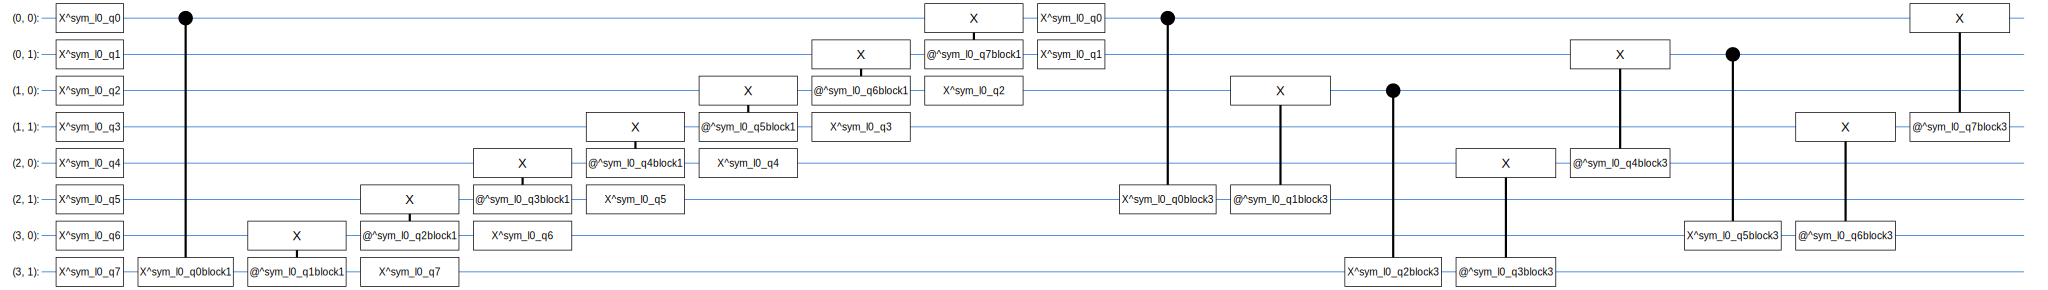

In [14]:
circuit = cirq.Circuit()
demo_builder = CircuitLayerBuilder(circuit=circuit,
                                   data_qubits = cirq.GridQubit.rect(4,2),
                                   readout=cirq.GridQubit(-1,-1),blocks=[1,3])
demo_builder.add_layer(gate=cirq.X)
SVGCircuit(circuit)

8
15


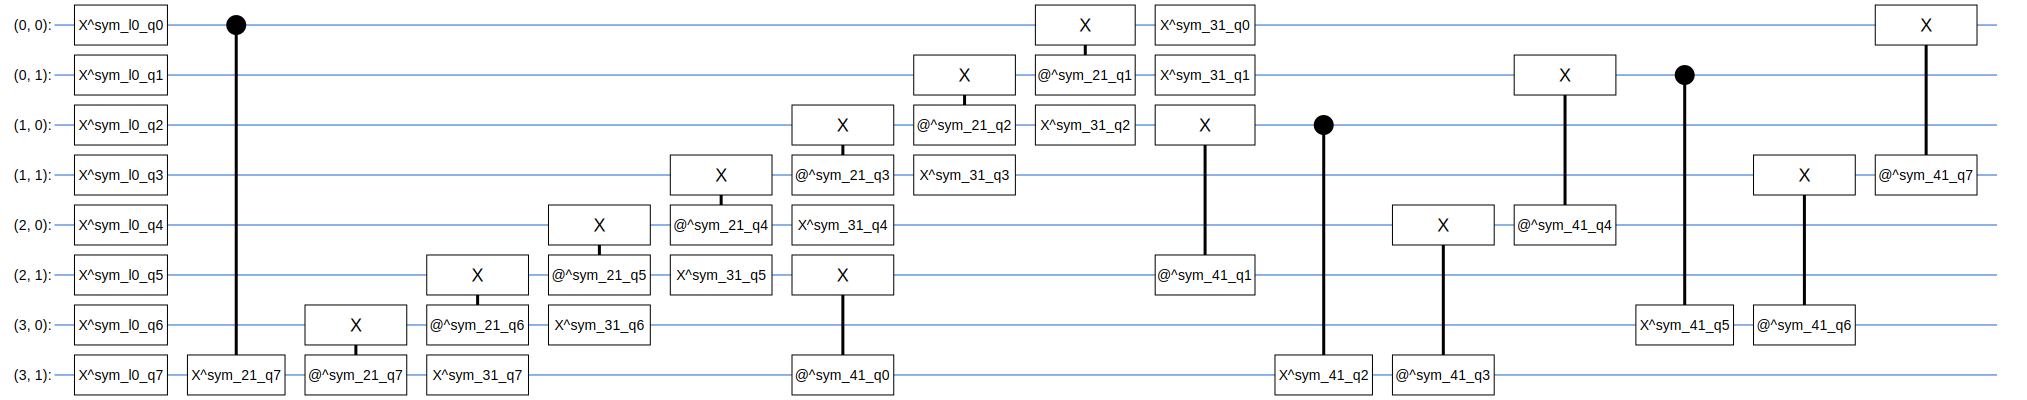

In [60]:
circuit = cirq.Circuit()
qubits = cirq.GridQubit.rect(4, 2) #data_qubits

#apply initial single qubit unitary gate

for qubit in range(len(qubits)):
    symbol = sympy.Symbol('sym_l' + str(0) + '_q' + str(qubit))      
    # first apply a gate to all the channels
    circuit.append(cirq.X(qubits[qubit])**(symbol))
    # wrap around and entangle last qubit with first qubit
# we have to apply a different for loop to match the structure
print(len(qubits))
for qubit in range(len(qubits)-1,0,-1):
    symbol = sympy.Symbol('sym_2' + str(1) + '_q' + str(qubit))
    if qubit == len(qubits)-1:
        # apply first cycle of controlled gates
        circuit.append(cirq.CNOT(qubits[0],qubits[qubit])**(symbol))
        circuit.append(cirq.CNOT(qubits[qubit],qubits[qubit-1])**(symbol))
    else:
        circuit.append(cirq.CNOT(qubits[qubit],qubits[qubit-1])**(symbol))
for qubit in range(len(qubits)):
    symbol = sympy.Symbol('sym_3' + str(1) + '_q' + str(qubit))
    # first apply a gate to all the channels
    circuit.append(cirq.X(qubits[qubit])**(symbol))

# need to generalize this

symbol = sympy.Symbol('sym_4' + str(1) + '_q' + str(0))
circuit.append(cirq.CNOT(qubits[qubit],qubits[5])**(symbol))
symbol = sympy.Symbol('sym_4' + str(1) + '_q' + str(1))
circuit.append(cirq.CNOT(qubits[5],qubits[2])**(symbol))
symbol = sympy.Symbol('sym_4' + str(1) + '_q' + str(2))
circuit.append(cirq.CNOT(qubits[2],qubits[7])**(symbol))
symbol = sympy.Symbol('sym_4' + str(1) + '_q' + str(3))
circuit.append(cirq.CNOT(qubits[7],qubits[4])**(symbol))
symbol = sympy.Symbol('sym_4' + str(1) + '_q' + str(4))
circuit.append(cirq.CNOT(qubits[4],qubits[1])**(symbol))
symbol = sympy.Symbol('sym_4' + str(1) + '_q' + str(5))
circuit.append(cirq.CNOT(qubits[1],qubits[6])**(symbol))
symbol = sympy.Symbol('sym_4' + str(1) + '_q' + str(6))
circuit.append(cirq.CNOT(qubits[6],qubits[3])**(symbol))
symbol = sympy.Symbol('sym_4' + str(1) + '_q' + str(7))
circuit.append(cirq.CNOT(qubits[3],qubits[0])**(symbol))

# readout 

readout = cirq.Z(qubits[0])

# Build the Keras model.
#qlayer = tfq.layers.PQC(circuit, readout)
print(len(qlayer.get_weights()[0]))
model = tf.keras.Sequential([
    # The input is the data-circuit, encoded as a tf.string
    tf.keras.layers.Input(shape=(), dtype=tf.string),
    # The PQC layer returns the expected value of the readout gate, range [-1,1].
    qlayer,
])
SVGCircuit(circuit)

In [ ]:
class CircuitLayerBuilder():
    def __init__(self, circuit, data_qubits, readout, repeat_dropout=0, overlap_dropout=False):

    self.data_qubits = data_qubits
    self.readout = readout
    self.curr_layer_id = 0
    self.circuit = circuit
    
    def add_layer(self, gate, apply_dropout=False):
    

Build an example circuit layer to see how it looks:

[cirq.GridQubit(0, 0), cirq.GridQubit(0, 1), cirq.GridQubit(1, 0), cirq.GridQubit(1, 1), cirq.GridQubit(2, 0), cirq.GridQubit(2, 1), cirq.GridQubit(3, 0), cirq.GridQubit(3, 1)]
self.dropout_blacklist =
[]


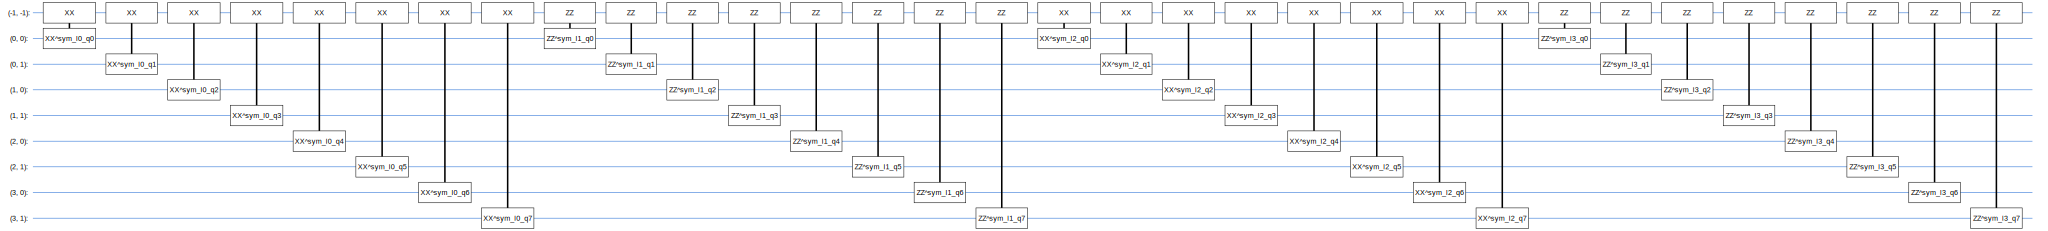

In [13]:
# TEST CELL to make sure CircuitLayerBuilder works properly
circuit = cirq.Circuit()
demo_builder = CircuitLayerBuilder(circuit=circuit,
                                   data_qubits = cirq.GridQubit.rect(4,2),
                                   readout=cirq.GridQubit(-1,-1))

demo_builder.add_layer(gate=cirq.XX)
demo_builder.add_layer(gate=cirq.ZZ, apply_dropout=True)
demo_builder.add_layer(gate=cirq.XX, apply_dropout=False)
demo_builder.add_layer(gate=cirq.ZZ, apply_dropout=False)

SVGCircuit(circuit)

Now build a two-layered model, matching the data-circuit size, and include the preparation and readout operations.

In [50]:
def create_quantum_model(apply_dropout=False, n_dropout=5, builder=None, computed_weights_arr=None):
    """Create a QNN model circuit and readout operation to go along with it."""
    data_qubits = cirq.GridQubit.rect(4, 4)  # a 4x4 grid.
    readout = cirq.GridQubit(-1, -1)         # a single qubit at [-1,-1]
    circuit = cirq.Circuit()
    
    # Prepare the readout qubit.
    circuit.append(cirq.X(readout))
    circuit.append(cirq.H(readout))
    
    if builder is None or computed_weights_arr is None:
        builder = CircuitLayerBuilder(
            circuit=circuit,
            data_qubits=data_qubits,
            readout=readout,
            repeat_dropout=n_dropout)
    else:
        builder.rebuild(circuit, data_qubits, readout, computed_weights_arr, preserve_dropout=apply_dropout)

    # Then add layers (TODO: experiment by adding more).
    builder.add_layer(cirq.XX, False)
    builder.add_layer(cirq.ZZ, apply_dropout) # only drop out one qubit as per Schuld
    builder.add_layer(cirq.XX, False)
    builder.add_layer(cirq.ZZ, False)

    # Finally, prepare the readout qubit.
    circuit.append(cirq.H(readout))

    return builder, circuit, cirq.Z(readout)

In [53]:
_, model_circuit, model_readout = create_quantum_model(apply_dropout=True)
SVGCircuit(model_readout)

self.dropout_blacklist =
[]
Dropped out qubit id 11
Dropped out qubit id 11
Dropped out qubit id 11


AttributeError: 'SingleQubitPauliStringGateOperation' object has no attribute 'moments'

### 2.2 Wrap the model-circuit in a tfq-keras model

Build the Keras model with the quantum components. This model is fed the "quantum data", from `x_train_circ`, that encodes the classical data. It uses a *Parametrized Quantum Circuit* layer, `tfq.layers.PQC`, to train the model circuit, on the quantum data.

To classify these images, <a href="https://arxiv.org/pdf/1802.06002.pdf" class="external">Farhi et al.</a> proposed taking the expectation of a readout qubit in a parameterized circuit. The expectation returns a value between 1 and -1.

In [52]:
# Build the Keras model.
qlayer = tfq.layers.PQC(model_circuit, model_readout)
print(len(qlayer.get_weights()[0]))
model = tf.keras.Sequential([
    # The input is the data-circuit, encoded as a tf.string
    tf.keras.layers.Input(shape=(), dtype=tf.string),
    # The PQC layer returns the expected value of the readout gate, range [-1,1].
    qlayer,
])

64


Next, describe the training procedure to the model, using the `compile` method.

Since the the expected readout is in the range `[-1,1]`, optimizing the hinge loss is a somewhat natural fit. 

Note: Another valid approach would be to shift the output range to `[0,1]`, and treat it as the probability the model assigns to class `3`. This could be used with a standard a `tf.losses.BinaryCrossentropy` loss.

To use the hinge loss here you need to make two small adjustments. First convert the labels, `y_train_nocon`, from boolean to `[-1,1]`, as expected by the hinge loss.

In [77]:
y_train_hinge = 2.0*y_train_nocon-1.0
y_test_hinge = 2.0*y_test-1.0

Second, use a custiom `hinge_accuracy` metric that correctly handles `[-1, 1]` as the `y_true` labels argument. 
`tf.losses.BinaryAccuracy(threshold=0.0)` expects `y_true` to be a boolean, and so can't be used with hinge loss).

In [78]:
def hinge_accuracy(y_true, y_pred):
    y_true = tf.squeeze(y_true) > 0.0
    y_pred = tf.squeeze(y_pred) > 0.0
    result = tf.cast(y_true == y_pred, tf.float32)

    return tf.reduce_mean(result)

In [85]:
model.compile(
    loss=tf.keras.losses.Hinge(),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=[hinge_accuracy])

In [86]:
print(model.summary())

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
pqc_2 (PQC)                  (None, 1)                 15        
Total params: 15
Trainable params: 15
Non-trainable params: 0
_________________________________________________________________
None


## 3. TensorBoard

In [83]:
logdir = "tb_logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
file_writer = tf.summary.create_file_writer(logdir + "/metrics")
file_writer.set_as_default()
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir, histogram_freq=1)


### Train the quantum model

Now train the model—this takes about 45 min. If you don't want to wait that long, use a small subset of the data (set `NUM_EXAMPLES=500`, below). This doesn't really affect the model's progress during training (it only has 32 parameters, and doesn't need much data to constrain these). Using fewer examples just ends training earlier (5min), but runs long enough to show that it is making progress in the validation logs.

In [88]:
EPOCHS = 20
DROPOUT_EPOCHS = 2 # keep qubits dropped out for this num of epochs
BATCH_SIZE = 32
NUM_EXAMPLES = len(x_train_tfcirc)
#NUM_EXAMPLES=None

In [89]:
x_train_tfcirc_sub = x_train_tfcirc[:NUM_EXAMPLES]
y_train_hinge_sub = y_train_hinge[:NUM_EXAMPLES]

In [90]:
model.fit(
  x_train_tfcirc_sub, y_train_hinge_sub,
  batch_size=32,
  epochs=EPOCHS,
  verbose=1,
  validation_data=(x_test_tfcirc, y_test_hinge),
  callbacks=[tensorboard_callback])

Epoch 1/20
324/324 [==============================] - 17s 52ms/step - loss: 1.0023 - hinge_accuracy: 0.4996 - val_loss: 0.7915 - val_hinge_accuracy: 0.6356
Epoch 2/20
324/324 [==============================] - 14s 43ms/step - loss: 1.0027 - hinge_accuracy: 0.4982 - val_loss: 0.7798 - val_hinge_accuracy: 0.6356
Epoch 3/20
324/324 [==============================] - 14s 42ms/step - loss: 1.0087 - hinge_accuracy: 0.4943 - val_loss: 0.7626 - val_hinge_accuracy: 0.6356
Epoch 4/20
324/324 [==============================] - 14s 42ms/step - loss: 1.0055 - hinge_accuracy: 0.4967 - val_loss: 0.7425 - val_hinge_accuracy: 0.6356
Epoch 5/20
324/324 [==============================] - 14s 44ms/step - loss: 0.9955 - hinge_accuracy: 0.4974 - val_loss: 0.7359 - val_hinge_accuracy: 0.6321
Epoch 6/20
324/324 [==============================] - 14s 43ms/step - loss: 1.0007 - hinge_accuracy: 0.4986 - val_loss: 0.7181 - val_hinge_accuracy: 0.6321
Epoch 7/20
324/324 [==============================] - 15s 46ms/s

Training this model to convergence should achieve >85% accuracy on the test set.

In [41]:
def train_model(apply_dropout=False):
    for i in range(EPOCHS):        
        # HACK - build new quantum circuit for each epoch and copy over the weights from the old one
        if i == EPOCHS-1:
            # Never use dropout on the last epoch; we can't get sane results otherwise
            apply_dropout = False
        
        if i == 0:
            model_builder, model_circuit, model_readout = create_quantum_model(apply_dropout, DROPOUT_EPOCHS)
            qlayer = tfq.layers.PQC(model_circuit, model_readout)
        else:
            model_builder, model_circuit, model_readout = create_quantum_model(apply_dropout, -1, model_builder, qlayer.get_weights()[0])
            qlayer_new = tfq.layers.PQC(model_circuit, model_readout,
                                        initializer=tf.keras.initializers.Zeros)
            curr_l = model_builder.get_builder_weights()
            qlayer_new.set_weights([np.array(curr_l, dtype=np.float32)])
            qlayer = qlayer_new

        model = tf.keras.Sequential([
            tf.keras.layers.Input(shape=(), dtype=tf.string),
            qlayer,
        ])
        model.compile(
            loss=tf.keras.losses.Hinge(),
            optimizer=tf.keras.optimizers.Adam(),
            metrics=[hinge_accuracy])

        # Now fit the model for this epoch
        model.fit(
              x_train_tfcirc_sub, y_train_hinge_sub,
              batch_size=32,
              epochs=1,
              verbose=1,
              validation_data=(x_test_tfcirc, y_test_hinge),
              callbacks=[tensorboard_callback])
    print(model.loss())
    tf.summary.scalar('loss', train_loss.result(), step=i)
    tf.summary.scalar('accuracy', train_accuracy.result(), step=i)
    return model

In [42]:
model = train_model(apply_dropout=False)

16/16 [==============================] - 42s 3s/step - loss: 1.0024 - hinge_accuracy: 0.4368 - val_loss: 1.0040 - val_hinge_accuracy: 0.4451
self.dropped_out_qubit_ids = 
[]
 2/16 [==>...........................] - ETA: 19s - loss: 0.9966 - hinge_accuracy: 0.5547

KeyboardInterrupt: 

In [ ]:
print("Non-dropout training set perf:")
model.evaluate(x_train_tfcirc_sub, y_train_hinge_sub)
print("Non-dropout test set perf:")
qnn_results = model.evaluate(x_test_tfcirc, y_test)

In [ ]:
dropout_model = train_model(apply_dropout=True)

In [ ]:
print("Dropout training set perf:")
dropout_model.evaluate(x_train_tfcirc_sub, y_train_hinge_sub)
print("Dropout test set perf:")
qnn_results = dropout_model.evaluate(x_test_tfcirc, y_test)

Note: The training accuracy reports the average over the epoch. The validation accuracy is evaluated at the end of each epoch.

## 4. Classical neural network

While the quantum neural network works for this simplified MNIST problem, a basic classical neural network can easily outperform a QNN on this task. After a single epoch, a classical neural network can achieve >98% accuracy on the holdout set.

In the following example, a classical neural network is used for for the 3-6 classification problem using the entire 28x28 image instead of subsampling the image. This easily converges to nearly 100% accuracy of the test set.

In [ ]:
def create_classical_model():
    # A simple model based off LeNet from https://keras.io/examples/mnist_cnn/
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv2D(32, [3, 3], activation='relu', input_shape=(28,28,1)))
    model.add(tf.keras.layers.Conv2D(64, [3, 3], activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(tf.keras.layers.Dropout(0.25))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(128, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.Dense(1))
    return model


model = create_classical_model()
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

model.summary()

In [ ]:
model.fit(x_train,
          y_train,
          batch_size=128,
          epochs=1,
          verbose=1,
          validation_data=(x_test, y_test))

cnn_results = model.evaluate(x_test, y_test)

The above model has nearly 1.2M parameters. For a more fair comparison, try a 37-parameter model, on the subsampled images:

In [ ]:
def create_fair_classical_model():
    # A simple model based off LeNet from https://keras.io/examples/mnist_cnn/
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Flatten(input_shape=(4,4,1)))
    model.add(tf.keras.layers.Dense(2, activation='relu'))
    model.add(tf.keras.layers.Dense(1))
    return model


model = create_fair_classical_model()
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

model.summary()

In [ ]:
model.fit(x_train_bin,
          y_train_nocon,
          batch_size=128,
          epochs=20,
          verbose=2,
          validation_data=(x_test_bin, y_test))

fair_nn_results = model.evaluate(x_test_bin, y_test)

## 5. Comparison

Higher resolution input and a more powerful model make this problem easy for the CNN. While a classical model of similar power (~32 parameters) trains to a similar accuracy in a fraction of the time. One way or the other, the classical neural network easily outperforms the quantum neural network. For classical data, it is difficult to beat a classical neural network.

In [ ]:
qnn_accuracy = qnn_results[1]
cnn_accuracy = cnn_results[1]
fair_nn_accuracy = fair_nn_results[1]

sns.barplot(["Quantum", "Classical, full", "Classical, fair"],
            [qnn_accuracy, cnn_accuracy, fair_nn_accuracy])